# Tree species classification project -- Data Science of Earth Oberservation
Group members:


Input file: .npy

In [73]:
# import the libraries you need

import os
import math
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain
import json
from jsonpath import jsonpath 

from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
import torch
# Folium setup.
import folium

# Step 1. Input the npy data

In [2]:
# get all npy files
## The ratio can also be changed
path= '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/data0129/npy/'
split_ratio = 0.8
dir_samples = path + "/*.npy"
samples = glob.glob(dir_samples)

# merge them
t_samples = np.load(samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(samples[1:])):
    try:
        t_samples = np.concatenate(
            (t_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(t_samples,)

train_num = int(len(t_samples)*split_ratio)

t_sample = t_samples[:train_num]
v_sample = t_samples[train_num:]


# define the train/valid path
t_samples_merge_path = path + "merge/train_merge.npy"
v_samples_merge_path = path + "merge/val_merge.npy"

np.save(t_samples_merge_path, t_sample)
np.save(v_samples_merge_path, v_sample)

print("Now all merge samples are saved!")

9it [00:00, 77.29it/s]


Now all merge samples are saved!


# Step 2. Data preparation

In [3]:
train_merge = np.load(t_samples_merge_path,allow_pickle=True)
val_merge = np.load(v_samples_merge_path,allow_pickle=True)
print (np.array(train_merge).shape)
print (np.array(val_merge).shape)

(2574, 1, 2)
(644, 1, 2)


In [4]:
kernel=9
bands=60
output_size = 10
number_samples = train_merge.shape[0]
data_train = train_merge[:,:,0]

X_train= np.zeros((number_samples,  kernel,kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train[i,:] = data_train[i,0]

Y_train = np.reshape(train_merge[:,:,1],number_samples).astype(int)



In [5]:

number_samples = val_merge.shape[0]
data_val = val_merge[:,:,0]
X_val= np.zeros((number_samples,   kernel,kernel,bands), dtype=float)

for i in range(0,number_samples-1):
    X_val[i,:] = data_val[i,0]

Y_val = np.reshape(val_merge[:,:,1],number_samples).astype(int)

In [6]:
number_samples = X_train.shape[0]
X_train_rf = np.reshape(X_train, (number_samples,  kernel*kernel*bands))
X_train_rf= np.array(pd.DataFrame(X_train_rf).fillna(0))
print("Post-processed S2_train data shape: ", X_train_rf.shape)

Post-processed S2_train data shape:  (2574, 4860)


In [7]:
number_samples_v = X_val.shape[0]
X_val_rf = np.reshape(X_val, (number_samples_v, kernel*kernel*bands))
X_val_rf= np.array(pd.DataFrame(X_val_rf).fillna(0))
print("Post-processed S2_val data shape: ", X_val_rf.shape)

Post-processed S2_val data shape:  (644, 4860)


# Step 3. Random forest classification

Random Forest: Random Forest is a supervised learning algorithm, it can be used to classify tree species using Sentinel-2 imagery.

In [8]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train_rf, Y_train)

RandomForestClassifier(random_state=0)

In [9]:
y_pred_rf = rf_classifier.predict(X_val_rf)

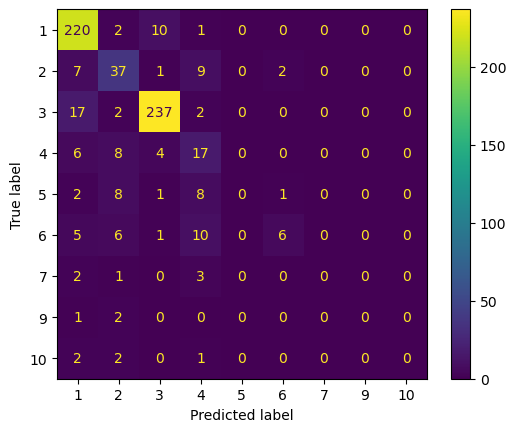

Accuracy Random Forest Classifier:  0.8027950310559007


In [10]:
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rf)
plt.show()

acc_rf = accuracy_score(Y_val, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

# Step 4. Artificial Nueral Network (ANN) classification

In [11]:
number_samples = X_train.shape[0]
X_train_nn= np.zeros((number_samples,  kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train_nn[i,:] = np.reshape(X_train[i,:], (  kernel*kernel,bands))
    X_train_nn[i,:]= np.array(pd.DataFrame(X_train_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_train_nn.shape)

Post-processed S2_train data shape:  (2574, 81, 60)


In [12]:
number_samples = X_train.shape[0]
X_train_nn0= np.zeros((number_samples,  kernel,4,kernel,bands), dtype=float)
X_train_nn1= np.zeros((number_samples,  kernel*4,kernel,4,bands), dtype=float)
X_train_nn2= np.zeros((number_samples,  kernel*4,kernel,bands), dtype=float)
X_train_nn3= np.zeros((number_samples,  kernel*4,kernel*4,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train_nn0[i,:] = np.stack((np.array(X_train[i,:]),np.array(X_train[i,:]),np.array(X_train[i,:]),np.array(X_train[i,:])),axis=1)
    X_train_nn2[i,:] = np.reshape(X_train_nn0[i,:], (  kernel*4,kernel,bands))
    X_train_nn1[i,:] = np.stack((np.array(X_train_nn2[i,:]),np.array(X_train_nn2[i,:]),np.array(X_train_nn2[i,:]),np.array(X_train_nn2[i,:])),axis=2)
    
    X_train_nn3[i,:] = np.reshape(X_train_nn1[i,:], (  kernel*4,kernel*4,bands))
   # X_train_nn2[i,:]= np.array(pd.DataFrame(X_train_nn2[i,:]).fillna(0))
    #X_train_nn2[i,:]= np.array(pd.DataFrame(X_train_nn2[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_train_nn3.shape)

Post-processed S2_train data shape:  (2574, 36, 36, 60)


In [13]:
number_samples = X_val.shape[0]
X_val_nn0= np.zeros((number_samples,  kernel,4,kernel,bands), dtype=float)
X_val_nn1= np.zeros((number_samples,  kernel*4,kernel,4,bands), dtype=float)
X_val_nn2= np.zeros((number_samples,  kernel*4,kernel,bands), dtype=float)
X_val_nn3= np.zeros((number_samples,  kernel*4,kernel*4,bands), dtype=float)
for i in range(0,number_samples-1):
    X_val_nn0[i,:] = np.stack((np.array(X_val[i,:]),np.array(X_val[i,:]),np.array(X_val[i,:]),np.array(X_val[i,:])),axis=1)
    X_val_nn2[i,:] = np.reshape(X_val_nn0[i,:], (  kernel*4,kernel,bands))
    X_val_nn1[i,:] = np.stack((np.array(X_val_nn2[i,:]),np.array(X_val_nn2[i,:]),np.array(X_val_nn2[i,:]),np.array(X_val_nn2[i,:])),axis=2)
    
    X_val_nn3[i,:] = np.reshape(X_val_nn1[i,:], (  kernel*4,kernel*4,bands))
   # X_train_nn2[i,:]= np.array(pd.DataFrame(X_train_nn2[i,:]).fillna(0))
    #X_train_nn2[i,:]= np.array(pd.DataFrame(X_train_nn2[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_val_nn3.shape)

Post-processed S2_train data shape:  (644, 36, 36, 60)


In [14]:
input_size=( kernel*kernel,bands)

In [15]:
number_samples = X_val.shape[0]
X_val_nn= np.zeros((number_samples,   kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_val_nn[i,:] = np.reshape(X_val[i,:], (  kernel*kernel,bands))
    X_val_nn[i,:]= np.array(pd.DataFrame(X_val_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_val_nn.shape)

Post-processed S2_train data shape:  (644, 81, 60)


In [20]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=input_size),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(output_size, activation='softmax')
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [83]:
history = simple_model.fit(X_train_nn, Y_train, epochs=200,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0,validation_data=(X_val_nn, Y_val))

Epoch 1/200
81/81 [==============================] - 1s 9ms/sample - loss: 0.8262 - accuracy: 0.7036 - val_loss: 0.8829 - val_accuracy: 0.6475
Epoch 21/200
81/81 [==============================] - 1s 7ms/sample - loss: 0.7156 - accuracy: 0.7300 - val_loss: 0.6891 - val_accuracy: 0.7578
Epoch 41/200
81/81 [==============================] - 1s 8ms/sample - loss: 0.6835 - accuracy: 0.7451 - val_loss: 0.7572 - val_accuracy: 0.7391
Epoch 61/200
81/81 [==============================] - 1s 7ms/sample - loss: 0.5937 - accuracy: 0.7813 - val_loss: 0.7252 - val_accuracy: 0.7702
Epoch 81/200
81/81 [==============================] - 1s 7ms/sample - loss: 0.5805 - accuracy: 0.7840 - val_loss: 0.7522 - val_accuracy: 0.7640
Epoch 101/200
81/81 [==============================] - 1s 7ms/sample - loss: 0.5926 - accuracy: 0.7797 - val_loss: 0.7112 - val_accuracy: 0.7717
Epoch 121/200
81/81 [==============================] - 1s 7ms/sample - loss: 0.5838 - accuracy: 0.7708 - val_loss: 0.7815 - val_accuracy

In [84]:
y_pred_dl_p = simple_model.predict(X_val_nn)

print("Prediction example: ", y_pred_dl_p[0,:], " Class: ", np.argmax(y_pred_dl_p[0,:]))

21/21 [==============================] - 0s 3ms/step
Prediction example:  [0.0000000e+00 1.3339710e-03 9.9026527e-13 9.9866605e-01 1.2793464e-09
 6.3541268e-17 1.5306542e-10 1.4528106e-14 1.3063620e-11 4.8574956e-23]  Class:  3


2023-01-31 02:14:57.089916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


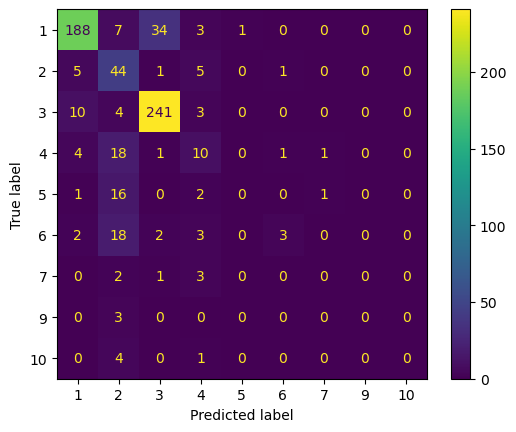

Accuracy Simple Deep Learning model:  0.7546583850931677


In [85]:
y_pred_dl = np.argmax(y_pred_dl_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_dl)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_dl)
print("Accuracy Simple Deep Learning model: ", acc_dl)

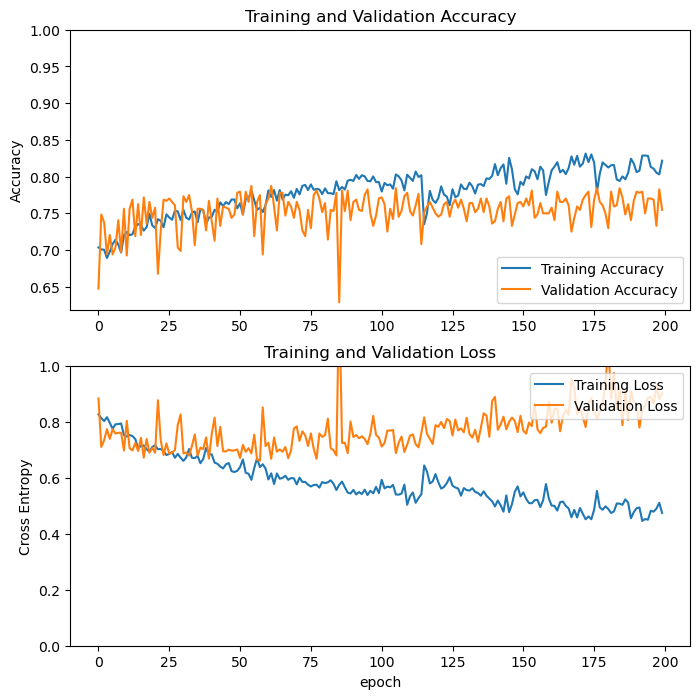

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [87]:
fine_tune_epochs = 200
initial_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = simple_model.fit(X_train_nn,Y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 200/210
81/81 [==============================] - 1s 10ms/step - loss: 0.4728 - accuracy: 0.8178 - val_loss: 0.9823 - val_accuracy: 0.7609
Epoch 201/210
81/81 [==============================] - 1s 9ms/step - loss: 0.4333 - accuracy: 0.8345 - val_loss: 0.9400 - val_accuracy: 0.7407
Epoch 202/210
81/81 [==============================] - 1s 9ms/step - loss: 0.4749 - accuracy: 0.8182 - val_loss: 0.9117 - val_accuracy: 0.7655
Epoch 203/210
81/81 [==============================] - 1s 8ms/step - loss: 0.4570 - accuracy: 0.8256 - val_loss: 0.8614 - val_accuracy: 0.7655
Epoch 204/210
81/81 [==============================] - 1s 8ms/step - loss: 0.4291 - accuracy: 0.8271 - val_loss: 0.9440 - val_accuracy: 0.7516
Epoch 205/210
81/81 [==============================] - 1s 8ms/step - loss: 0.4394 - accuracy: 0.8283 - val_loss: 0.9422 - val_accuracy: 0.7826
Epoch 206/210
81/81 [==============================] - 1s 8ms/step - loss: 0.4460 - accuracy: 0.8244 - val_loss: 0.9118 - val_accuracy: 0.768

In [88]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

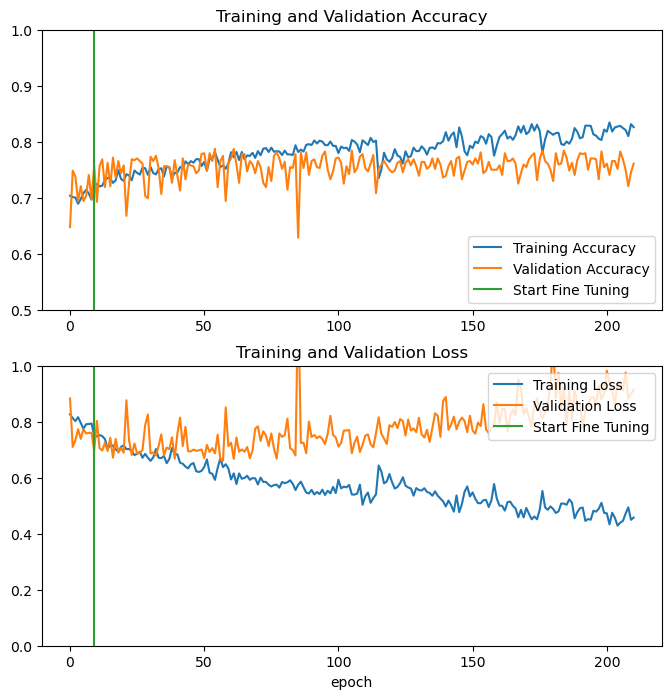

In [89]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [90]:
loss, accuracy = simple_model.evaluate(X_val_nn,Y_val)
print('Test accuracy :', accuracy)

21/21 [==============================] - 0s 7ms/step - loss: 0.9146 - accuracy: 0.7609
Test accuracy : 0.760869562625885


# Step 5. Convolutional Neural Networks (CNNs) classification

Convolutional Neural Networks (CNNs): These are commonly used for image classification tasks and have been shown to be effective for tree species classification using Sentinel-2 imagery.

In [78]:
CNNs_model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(kernel*kernel,bands,1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(128, (1,1), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16)
]
)

In [79]:

CNNs_model.summary() 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 81, 60, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 40, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 40, 30, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 15, 128)       8320      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 10, 7, 128)      

In [80]:

CNNs_model.add(layers.Flatten())
CNNs_model.add(layers.Dense(64, activation='relu'))
CNNs_model.add(layers.Dropout(0.5))
CNNs_model.add(layers.Dense(output_size))

In [81]:

CNNs_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 81, 60, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 40, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 40, 30, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 15, 128)       8320      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 10, 7, 128)      

In [82]:

CNNs_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = CNNs_model.fit(X_train_nn, Y_train, epochs=30,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=10)],  verbose=0,
                    validation_data=(X_val_nn, Y_val))
     

Epoch 1/30


2023-01-31 00:02:35.648177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-31 00:02:37.611993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 3s 31ms/sample - loss: 1.5197 - accuracy: 0.4122 - val_loss: 1.0777 - val_accuracy: 0.5652
Epoch 11/30
81/81 [==============================] - 1s 18ms/sample - loss: 0.7156 - accuracy: 0.7393 - val_loss: 0.6487 - val_accuracy: 0.7764
Epoch 21/30
81/81 [==============================] - 2s 19ms/sample - loss: 0.6157 - accuracy: 0.7708 - val_loss: 0.6374 - val_accuracy: 0.7888


In [70]:
y_pred_cnn_p = CNNs_model.predict(X_val_nn)

print("Prediction example: ", y_pred_cnn_p[0,:], " Class: ", np.argmax(y_pred_cnn_p[0,:]))

15/21 [====================>.........] - ETA: 0s

2023-01-30 23:54:46.139251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 10ms/step
Prediction example:  [-13.326411    7.1052504  -9.782258   13.045093   -1.092611   -5.4421988
 -11.488007   -5.75469   -11.907173   -5.6451697]  Class:  3


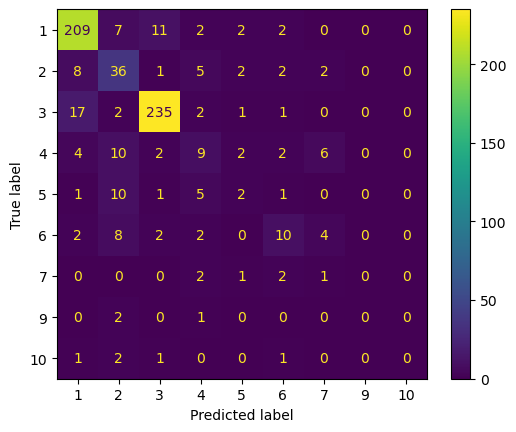

Accuracy Simple Deep Learning model:  0.7795031055900621


In [71]:
y_pred_cnn = np.argmax(y_pred_cnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_cnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_cnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

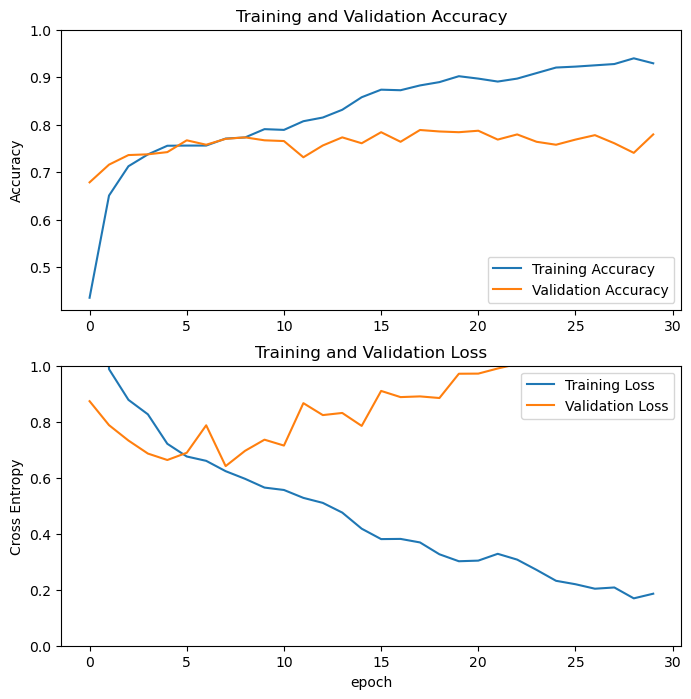

In [72]:

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [76]:
fine_tune_epochs = 30
initial_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
opt = SGD(lr=1e-4, momentum=0.9)
CNNs_model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
history_fine = CNNs_model.fit(X_train_nn,Y_train,
                         epochs=total_epochs,
                         initial_epoch=history2.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 30/40


ValueError: in user code:

    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


In [52]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

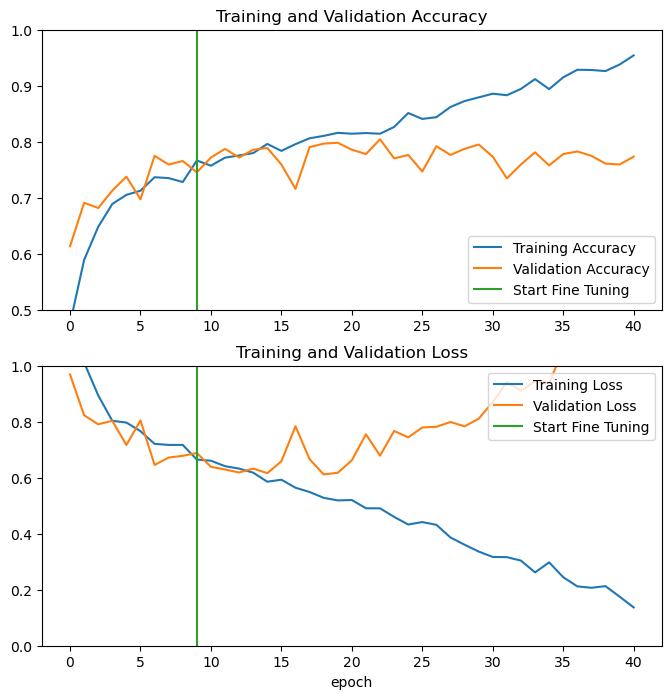

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [54]:
loss, accuracy = CNNs_model.evaluate(X_val_nn,Y_val)
print('Test accuracy :', accuracy)

21/21 [==============================] - 0s 14ms/step - loss: 1.3330 - accuracy: 0.7733
Test accuracy : 0.7732919454574585


# Step 6. - Residual Network: ResNet

A residual neural network (ResNet) is an artificial neural network that imitate the pyramidal cells in the cerebral cortex. Particularly, the ResNet architecture consists of skip connections or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between. These *cells* are known as *residual block*.

ResNets connection weights are easier to optimize (especially for gradient descent-based optimizers) because the short cuts contribute to alleviate the vanishing gradient problem.

In practice, the degradation problem (i.e., increasing the depth of a network leads to a decrease in its performance) is mitigated, and the observed performance (when the number of hidden layers increase) is much closer to the theoretical one.

In [91]:
model_rn = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(  kernel*kernel,bands,1), 
    pooling=None,
    classes=output_size)

model_rn.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [92]:
history3=model_rn.fit(X_train_nn, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0,validation_data=(X_val_nn, Y_val))


Epoch 1/100


2023-01-31 02:16:05.972222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-31 02:16:18.277546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 17s 210ms/sample - loss: 1.5522 - accuracy: 0.5719 - val_loss: 1.6133 - val_accuracy: 0.3602
Epoch 21/100
81/81 [==============================] - 9s 111ms/sample - loss: 0.6656 - accuracy: 0.7630 - val_loss: 0.7357 - val_accuracy: 0.7314
Epoch 41/100
81/81 [==============================] - 9s 111ms/sample - loss: 0.6982 - accuracy: 0.7362 - val_loss: 0.9340 - val_accuracy: 0.6584
Epoch 61/100
81/81 [==============================] - 9s 108ms/sample - loss: 0.7701 - accuracy: 0.7358 - val_loss: 36.4575 - val_accuracy: 0.0652
Epoch 81/100
81/81 [==============================] - 8s 103ms/sample - loss: 0.4576 - accuracy: 0.8329 - val_loss: 1.0126 - val_accuracy: 0.6910


2023-01-31 02:47:06.725246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 44ms/step


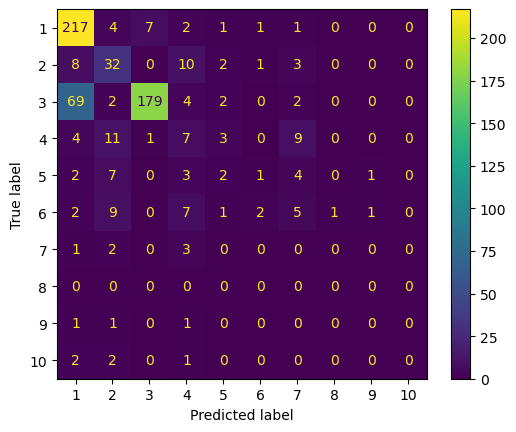

Accuracy ResNet-50 model:  0.6816770186335404


In [93]:
y_pred_rn_p = model_rn.predict(X_val_nn)

y_pred_rn = np.argmax(y_pred_rn_p, axis=1)

##print(y_pred_rn)
#print(Y_val)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rn)
plt.show()

acc_rn = accuracy_score(Y_val, y_pred_rn)
print("Accuracy ResNet-50 model: ", acc_rn)

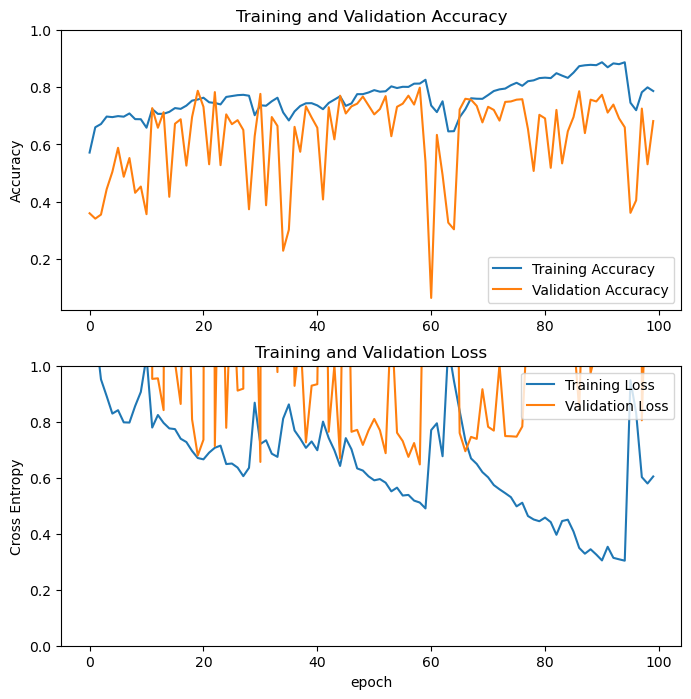

In [94]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [63]:

inputs = tf.keras.layers.Input(shape=(input_size[0], input_size[1],1), name="input_image")
VGG16 = tf.keras.applications.VGG16( input_tensor=None,
                                               include_top=False,
                                               input_shape=[input_size[0], input_size[1],3], 
                                               weights='imagenet',
                                               classes=output_size,
                                               pooling=None)

In [64]:
VGG16.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 81, 60, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 81, 60, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 81, 60, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 40, 30, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 40, 30, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 40, 30, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 15, 128)       0     

In [66]:
#history4 = VGG16.fit(X_train_nn, Y_train, epochs=20,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=5)],  verbose=0,
#                    validation_data=(X_val_nn, Y_val))

Epoch 1/20


ValueError: in user code:

    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/engine/input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "vgg16" "                 f"(type Functional).
    
    Input 0 of layer "block1_conv1" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 81, 60)
    
    Call arguments received by layer "vgg16" "                 f"(type Functional):
      • inputs=tf.Tensor(shape=(None, 81, 60), dtype=float32)
      • training=True
      • mask=None


In [57]:
#y_pred_mbn_p = VGG16.predict(X_val_nn3)

#print("Prediction example: ", y_pred_mbn_p[0,:], " Class: ", np.argmax(y_pred_mbn_p[0,:]))

2023-01-30 03:10:02.842840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 26ms/step
Prediction example:  [0.03720302 0.31413996 0.08584212 0.35119244 0.07471129 0.04492516
 0.04931746 0.0426685 ]  Class:  3


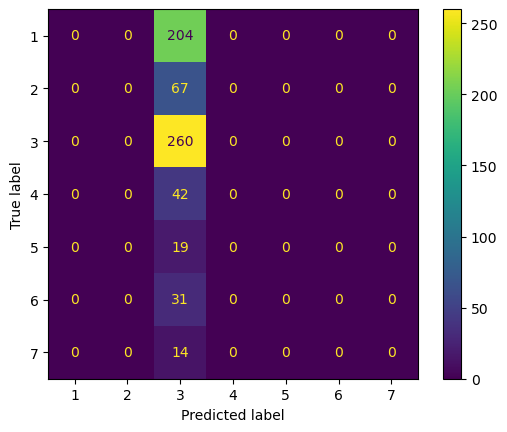

Accuracy Simple Deep Learning model:  0.40816326530612246


In [58]:
#y_pred_mbn = np.array(np.argmax(y_pred_mbn_p, axis=1)).astype(int)

#ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_mbn)
#plt.show()

#acc_dl = accuracy_score(Y_val, y_pred_mbn)
#print("Accuracy Simple Deep Learning model: ", acc_dl)

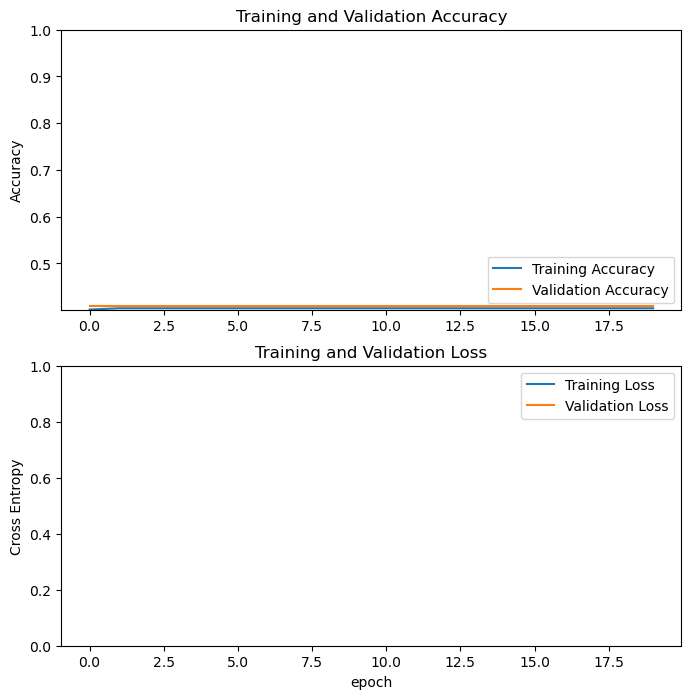

In [59]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Step 7. Recurrent Neural Networks (RNNs) classification

Recurrent Neural Networks (RNNs): RNNs can be used to analyze sequential data such as time series data, which can be useful for analyzing the temporal information present in Sentinel-2 imagery.

In [95]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 60

units = 64


# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(kernel*kernel, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(kernel*kernel, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [96]:
RNNs_model = build_model(allow_cudnn_kernel=True)

RNNs_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


history5=RNNs_model.fit(
    X_train_nn, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0, validation_data=(X_val_nn, Y_val), batch_size=batch_size
)

Epoch 1/100


2023-01-31 02:47:30.474091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-31 02:47:30.642174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-31 02:47:31.081048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-31 02:47:33.032165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-31 02:47:33.093589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 86ms/sample - loss: 1.8017 - accuracy: 0.4542 - val_loss: 1.8870 - val_accuracy: 0.4503
Epoch 21/100
41/41 [==============================] - 1s 31ms/sample - loss: 0.7851 - accuracy: 0.7308 - val_loss: 1.9917 - val_accuracy: 0.4984
Epoch 41/100
41/41 [==============================] - 1s 28ms/sample - loss: 0.7051 - accuracy: 0.7463 - val_loss: 0.7331 - val_accuracy: 0.7438
Epoch 61/100
41/41 [==============================] - 1s 31ms/sample - loss: 0.6531 - accuracy: 0.7618 - val_loss: 0.8453 - val_accuracy: 0.7236
Epoch 81/100
41/41 [==============================] - 1s 28ms/sample - loss: 0.6344 - accuracy: 0.7758 - val_loss: 1.3303 - val_accuracy: 0.6118


In [151]:
y_pred_rnn_p = RNNs_model.predict(X_val_nn)

print("Prediction example: ", y_pred_rnn_p[0,:], " Class: ", np.argmax(y_pred_rnn_p[0,:]))

2023-01-30 03:45:31.389740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-30 03:45:31.454910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 20ms/step
Prediction example:  [-2.3664777  -4.174246    0.71767694 -4.1441746   3.4144835   1.400006
  2.441797    3.0266728   0.17284378 -1.3956738 ]  Class:  4


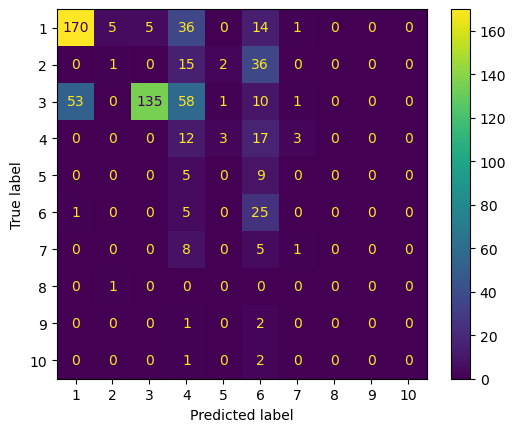

Accuracy Simple Deep Learning model:  0.5341614906832298


In [152]:
y_pred_rnn = np.argmax(y_pred_rnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_rnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

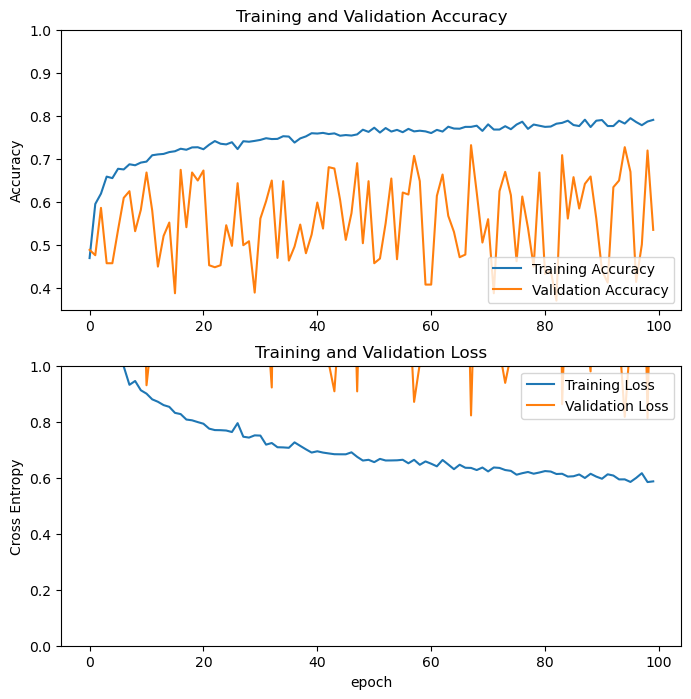

In [153]:

acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#fusion"""
fusion_softmax = y_pred_dl_p + y_pred_cnn_p + y_pred_rn_p + y_pred_rnn_p
fusion_label = np.argmax(fusion_softmax,axis=0).astype(np.int16)+1
ConfusionMatrixDisplay.from_predictions(Y_val, fusion_label)
plt.show()

acc_dl = accuracy_score(Y_val, fusion_label)
print("Accuracy Simple Deep Learning model: ", acc_dl)